Neben den standardmäßigen Packages zur Datenbearbeitung und Visualisierung benötigen wir sklearn zum Pre- und Postprocessing der Trainings- und Testdaten sowie die Packages für die Nutzung von Neuronalen Netzen, tensorflow und keras.

Wir importieren den Datensatz und verschaffen uns einen Überblick.

In [1]:
# import packages
# hide warnings
import warnings
warnings.filterwarnings('ignore')

# data handling
import pandas as pd
import numpy as np
import datetime as dt

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# pre- and postprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# neural network classification
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# ensure reproducable results
from numpy.random import seed
from tensorflow import set_random_seed
seed(1)
set_random_seed(2) 

# read data
df_raw_data = pd.read_csv('advertising.csv')

print(df_raw_data.head())

print('\n', df_raw_data['Country'].value_counts())

print('\n', df_raw_data['City'].value_counts())

   Daily Time Spent on Site  Age  Area Income  Daily Internet Usage  \
0                     68.95   35     61833.90                256.09   
1                     80.23   31     68441.85                193.77   
2                     69.47   26     59785.94                236.50   
3                     74.15   29     54806.18                245.89   
4                     68.37   35     73889.99                225.58   

                           Ad Topic Line            City  Male     Country  \
0     Cloned 5thgeneration orchestration     Wrightburgh     0     Tunisia   
1     Monitored national standardization       West Jodi     1       Nauru   
2       Organic bottom-line service-desk        Davidton     0  San Marino   
3  Triple-buffered reciprocal time-frame  West Terrifurt     1       Italy   
4          Robust logistical utilization    South Manuel     0     Iceland   

             Timestamp  Clicked on Ad  
0  2016-03-27 00:53:11              0  
1  2016-04-04 01:39:02  

Da wir keine Textverarbeitung in das Modell integrieren wollen und da die verschiedenen ortsbezognenen Informationen "Country" und "City" zu selten vorkommen um einen Zusammenhang daraus schließen zu können, reduzieren wir den Datensatz und verwenden nur einige der gegebenen Informationen. Die verbleibenden Daten betrachten wir noch etwas genauer.

In [2]:
# select columns
df_filtered = df_raw_data.drop(columns=['Ad Topic Line','Country','City'])

# detailed info
print('\n', df_filtered.info())
print('\n', df_filtered.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Male                      1000 non-null   int64  
 5   Timestamp                 1000 non-null   object 
 6   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 54.8+ KB

 None

        Daily Time Spent on Site          Age   Area Income  \
count               1000.000000  1000.000000   1000.000000   
mean                  65.000200    36.009000  55000.000080   
std                   15.853615     8.785562  13414.634022   
min                   32.600000    19.000000  13996.500000   
25%               

Es gibt 1000 Samples in unserem Datensatz, keine fehlenden Einträge und genau 50% der Nutzer haben die Werbung angeklickt ("Clicked on Ad" = 1).

Mit dem datetime Package lesen wir die Stunde aus dem "Timestamp" aus und behalten diese als einzige datumsbezogene Information. Außerdem skalieren wir die Input Daten mittels MinMax-Skalierung. Welchen Effekt dieser Skalierungsschritt hat, analysieren wir später.

In [3]:
# extract hour
df_filtered['Timestamp'] = pd.to_datetime(df_filtered['Timestamp'])
df_filtered['Hour'] = df_filtered['Timestamp'].dt.hour

df_filtered = df_filtered.drop(columns=['Timestamp'])

# min-max-scaling
df_filtered_scaled = df_filtered.copy()
scaled_columns = ['Daily Time Spent on Site', 'Age', 'Area Income','Daily Internet Usage','Hour']

scaler = MinMaxScaler()
for i in scaled_columns:
    df_filtered_scaled[i] = scaler.fit_transform(df_filtered[i].values.reshape(-1,1))
    
print(df_filtered_scaled.describe())

       Daily Time Spent on Site          Age  Area Income  \
count               1000.000000  1000.000000  1000.000000   
mean                   0.550743     0.404976     0.626119   
std                    0.269482     0.209180     0.204840   
min                    0.000000     0.000000     0.000000   
25%                    0.318885     0.238095     0.504446   
50%                    0.605388     0.380952     0.656847   
75%                    0.781022     0.547619     0.786005   
max                    1.000000     1.000000     1.000000   

       Daily Internet Usage         Male  Clicked on Ad         Hour  
count           1000.000000  1000.000000     1000.00000  1000.000000  
mean               0.455383     0.481000        0.50000     0.506957  
std                0.265785     0.499889        0.50025     0.302650  
min                0.000000     0.000000        0.00000     0.000000  
25%                0.206139     0.000000        0.00000     0.260870  
50%                0.474

In diesem Setting sind die getätigten Klicks auf die Werbeanzeige unsere gelabelted Daten bzw. die abhängige Variable, die wir vorhersagen wollen. Wir teilen unseren Datensatz auf in Training- und Testdaten.

In [4]:
# define input data and labeled output data
X = df_filtered_scaled.drop(columns=['Clicked on Ad']).values.astype('float')
y = df_filtered_scaled['Clicked on Ad'].values

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

Nun initialisieren wir das Neuronale Netz mit einem Hidden Layern, bestehend aus vier Neuronen mit "Rectifier Linear Unit" Aktivierungsfunktion. Da ein binäres Klassifikationsproblem vorliegt, besteht das Output Layer aus nur einem Neuron mit einer "Sigmoid" Aktivierungsfunktion. Entsprechend unserer sechs Features, hat auch das Inputlayer sechs Neuronen. Folgende Abbildung visualisiert die Netzwerkstruktur von "model_1".

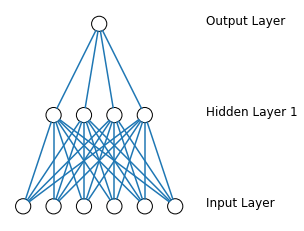

In [5]:
Image('network_architecture_model_1.png')

Mit 'compile()' geben wir an, welcher Optimierungsalgorithmus und welches Fehlermaß verwendet werden. Außerdem wird spezifiziert, welche Metriken während des Trainingsprozesses erfasst werden sollen. Wir möchten wissen, wieviele der Trainingsbeispiel über die Epochen richtig klassifiziert wurden.

Für das eigentlichen Lernen, welches durch "model.fit()" angestoßen wird, setzten wir noch einige Hyperparameter. Der Parameter "epochs" gibt an, wie häufig der gesamte Datensatz durchlaufen wird, was gleichbedeutend mit der Anzahl der Updates eines Neuronengewichts im Laufe des Lernprozesses ist. Der Trainingsdatensatz wird allerdings in jeder dieser Epochen nicht als Ganzes verarbeitet, sondern wiederum in mehrere Batches unterteilt. Jeder dieser Batches hat dabei die angegebene "batch_size" an Trainingsbeispielen.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 670 samples, validate on 330 samples
Epoch 1/20
670/670 - 0s - loss: 0.8176 - acc: 0.4940 - val_loss: 0.7745 - val_acc: 0.5121
Epoch 2/20
670/670 - 0s - loss: 0.7834 - acc: 0.4940 - val_loss: 0.7471 - val_acc: 0.5121
Epoch 3/20
670/670 - 0s - loss: 0.7546 - acc: 0.4940 - val_loss: 0.7237 - val_acc: 0.5121
Epoch 4/20
670/670 - 0s - loss: 0.7300 - acc: 0.4955 - val_loss: 0.7043 - val_acc: 0.5121
Epoch 5/20
670/670 - 0s - loss: 0.7101 - acc: 0.5000 - val_loss: 0.6881 - val_acc: 0.5364
Epoch 6/20
670/670 - 0s - loss: 0.6925 - acc: 0.5149 - val_loss: 0.6753 - val_acc: 0.5515
Epoch 7/20
670/670 - 0s - loss: 0.6785 - acc: 0.5537 - val_loss: 0.6648 - val_acc: 0.5848
Epoch 8/20
670/670 - 0s - loss: 0.6665 - acc: 0.5791 - val_loss: 0.6557 - val_acc: 0.6121
Epoch 9/20
670/670 - 0

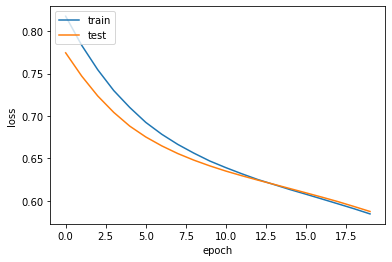

In [6]:
# build model
model_1 = keras.Sequential()

model_1.add(Dense(4, input_dim=X.shape[1], activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))
    
model_1.compile(optimizer='adam',
          loss='binary_crossentropy',
          metrics=['accuracy'])

# fit model
history_1 = model_1.fit(X_train, y_train, epochs=20, verbose=2, batch_size=50,
                    shuffle=True, validation_data=(X_test, y_test))

# visualize learning progress
plt.figure()
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

Dieser Plot visualisiert den Verlauf des Fehlers für Trainings- und Testdaten über die Epochen. Beide Kurven fallen, ohne gegen einen Grenzwert zu laufen, was dafür spricht, dass das Modell mit mit höherer Anzahl an Epochen noch weiter verbessert werden kann. Ein Fallen des Trainingsfehlers bei gleichzeitigem Anstieg des Testfehlers würde für ein Overfitting sprechen, wird aber hier nicht beobachtet.

Am Relevantesten ist, wie gut das Modell zur Vorhersage von Daten außerhalb der Trainingsdatenmenge geeignet ist. Zum einen können wir auch für die Testdaten die Genauigkeit durch Evaluation des Neuronalen Netzes angeben, zum anderen hilft die Confusion Matrix bei der Analyse der Vorhersagen.


test accuracy model_1: 0.7878788


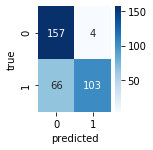

test samples: 330


In [7]:
# evaluate accuracy on test data
test_loss_1, test_acc_1 = model_1.evaluate(X_test, y_test, verbose=0)
print('\ntest accuracy model_1:', test_acc_1)

# list for accuracies of different models
accuracies = [test_acc_1]

# confusion matrix
y_test_pred_1 = model_1.predict_classes(X_test)

confusion_matrix_array_1 = confusion_matrix(y_test, y_test_pred_1)

figure = plt.figure(figsize=(2, 2))
sns.heatmap(confusion_matrix_array_1, annot=True, cmap='Blues', fmt='g')
plt.tight_layout()
plt.ylabel('true')
plt.xlabel('predicted')
plt.show()

print('test samples:', len(y_test))

Die Genauigkeit der Vorhersagen auf den Testdaten ist also 78.8%. Die Confusion Matrix gibt Aufschluss darüber, dass 66 der Beobachtungen mit tatsächlichem Klick auf die Werbung als Nicht-Klicks klassifiziert wurden, dies sind die False Negative Klassifikationen. Vier der Nicht-Klicks wurden fälschlicherweise als Klick, als False Positive, prognostiziert. Diese 70 Fehler entsprechen genau den fehlenden 21.3% für eine 100%-ige Genauigkeit. Die richtig klassifizierten Samples sind 103 True Positive und 157 True Negative Klassifikationen.

Um den Einfluss der Struktur eines Neuronalen Netzes und den einiger Hyperparameter zu demonstrieren, lernen wir im Folgenden drei weitere Neuronale Netze an und vergleichen den Lernprozess sowie die Prädiktionsgüte. Zunächst erhöhen wir lediglich die Anzahl der Epochen von 20 auf 100.

In [8]:
# same seed for reproducable and comparable results
seed(1)
set_random_seed(2) 

# build model with more epochs
model_2 = keras.Sequential()

model_2.add(Dense(4, input_dim=X.shape[1], activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))
    
model_2.compile(optimizer='adam',
          loss='binary_crossentropy',
          metrics=['accuracy'])

# fit model
history_2 = model_2.fit(X_train, y_train, epochs=100, verbose=0, batch_size=50,
                    shuffle=True, validation_data=(X_test, y_test))

# evaluate accuracy on test data
test_loss_2, test_acc_2 = model_2.evaluate(X_test, y_test, verbose=0)

# predict test data
y_test_pred_2 = model_2.predict_classes(X_test)

confusion_matrix_array_2 = confusion_matrix(y_test, y_test_pred_2)

accuracies.append(test_acc_2)
print('\ntest accuracy model_2:', test_acc_2)


test accuracy model_2: 0.93939394


Durch die zusätzlichen Epochen im Lernprozess, konnte die Genauigkeit deutlich gesteigert werden. Für "model_3" fügen wir nun ein weiteres Layer hinzu und übernehmen die Anzahl der Epochen von 100 wie bei "model_2". Folgende Abbildung visualisiert die Netzwerkstruktur von "model_3".

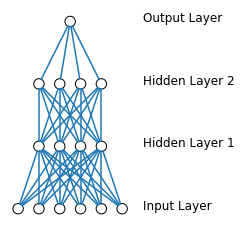

In [9]:
Image('network_architecture_model_3.png')

In [10]:
# same seed for reproducable and comparable results
seed(1)
set_random_seed(2) 

# build model with one additional layer
model_3 = keras.Sequential()

model_3.add(Dense(4, input_dim=X.shape[1], activation='relu'))
model_3.add(Dense(4, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))
    
model_3.compile(optimizer='adam',
          loss='binary_crossentropy',
          metrics=['accuracy'])

# fit model
history_3 = model_3.fit(X_train, y_train, epochs=100, verbose=0, batch_size=50,
                    shuffle=True, validation_data=(X_test, y_test))

# evaluate accuracy on test data
test_loss_3, test_acc_3 = model_3.evaluate(X_test, y_test, verbose=0)

# predict test data
y_test_pred_3 = model_3.predict_classes(X_test)

confusion_matrix_array_3 = confusion_matrix(y_test, y_test_pred_3)

accuracies.append(test_acc_3)
print('\ntest accuracy model_3:', test_acc_3)


test accuracy model_3: 0.94545454


Das zusätzliche Layer im Neuronalen Netz konnte keine signifikante Steigerung erwirken. In der letzten Variante, ist der Aufbau und die Wahl der Hyperparameter wie bei dem zuletzt trainierten "model_3", allerdings werden die Daten nicht wie oben zunächst einer MinMax-Skalierung unterzogen.

In [11]:
# same seed for reproducable and comparable results
seed(1)
set_random_seed(2)

# define input data and labeled output data
X = df_filtered.drop(columns=['Clicked on Ad']).values.astype('float')
y = df_filtered['Clicked on Ad'].values

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# build model with one additional layer
model_4 = keras.Sequential()

model_4.add(Dense(4, input_dim=X.shape[1], activation='relu'))
model_4.add(Dense(4, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))
    
model_4.compile(optimizer='adam',
          loss='binary_crossentropy',
          metrics=['accuracy'])

# fit model
history_4 = model_4.fit(X_train, y_train, epochs=100, verbose=0, batch_size=50,
                    shuffle=True, validation_data=(X_test, y_test))

# evaluate accuracy on test data
test_loss_4, test_acc_4 = model_4.evaluate(X_test, y_test, verbose=0)

# predict test data
y_test_pred_4 = model_4.predict_classes(X_test)

confusion_matrix_array_4 = confusion_matrix(y_test, y_test_pred_4)

accuracies.append(test_acc_4)
print('\ntest accuracy model_4:', test_acc_4)


test accuracy model_4: 0.4878788


accuracies: [0.79 0.94 0.95 0.49]


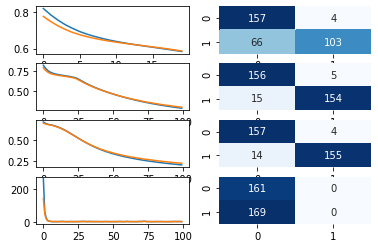

In [12]:
# create subplots
fig, axes = plt.subplots(4,2)

# learning progress
axes[0,0].plot(history_1.history['loss'])
axes[0,0].plot(history_1.history['val_loss'])

axes[1,0].plot(history_2.history['loss'])
axes[1,0].plot(history_2.history['val_loss'])

axes[2,0].plot(history_3.history['loss'])
axes[2,0].plot(history_3.history['val_loss'])

axes[3,0].plot(history_4.history['loss'])
axes[3,0].plot(history_4.history['val_loss'])

# confusion matrices
sns.heatmap(confusion_matrix_array_1, ax=axes[0,1], annot=True, cmap='Blues', cbar=False, fmt='g')
sns.heatmap(confusion_matrix_array_2, ax=axes[1,1], annot=True, cmap='Blues', cbar=False, fmt='g')
sns.heatmap(confusion_matrix_array_3, ax=axes[2,1], annot=True, cmap='Blues', cbar=False, fmt='g')
sns.heatmap(confusion_matrix_array_4, ax=axes[3,1], annot=True, cmap='Blues', cbar=False, fmt='g')

print('accuracies:', np.round(accuracies,2))

Durch die Erhöhung der Anzahl an Epochen im Lernprozess konnte eine Steigerung der Genauigkeit von 79% auf 94% erzielt werden. In diesem Fall hatte die Vergrößerung des Neuronalen Netzes durch ein zusätzliches Layer mit einer Steigerung i.H.v. 1%-Punkt nur einen geringen zusätzlichen positiven Einfluss. Ohne die MinMax-Skalierung gelingt es dem Algorithmus nicht die Gewichte des Neuronalen Netzes so anzupassen, dass die Genauigkeit der Vorhersagen höher als eine zufällige Prognose ist.